# Downloading Dataset

In [2]:
!gdown https: // drive.google.com/uc?id = 1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6


Downloading...
From: https://drive.google.com/uc?id=1DdGIJ4PZPlF2ikl8mNM9V-PdVxVLbQi6
To: /home/fsuser/AI_ENGINE/yolov5_tf_original/YOLOv5-tf/lol_dataset.zip
100%|████████████████████████████████████████| 347M/347M [00:04<00:00, 75.0MB/s]


Unzip the Dataset 📂

In [4]:
!unzip lol_dataset.zip


Archive:  lol_dataset.zip
replace lol_dataset/eval15/high/748.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


Directory `lol_dataset` 📁 structure 
```bash
.
├── eval15
│   ├── high
│   └── low
└── our485
    ├── high
    └── low

```

# Imports

In [1]:
import os
import cv2
import random
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Dataset Creation

In [14]:
from typing import List, Union
from rich.console import Console
from IPython.core.debugger import set_trace

random.seed(10)

IMAGE_SIZE = 128
BATCH_SIZE = 4
MAX_TRAIN_IMAGES = 300

@tf.function
def extract_patches(patch_size : List[int] = [180, 320], image : tf.Tensor = None):
    # patch_size = [180, 320]
    half_strides = list(map(lambda x: int(x/2), patch_size))
    # set_trace()
    extracted_patches = tf.image.extract_patches(
        images=tf.expand_dims(image, 0),
        sizes=[1, *patch_size, 1],
        strides=[1, *half_strides, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    return extracted_patches


@tf.function
def read_image(image_path):
    '''
    reads and normalizes the image 🖼️
    image is being read as bytes and then decoded into a uint8 tensor
    it is then converted into a float32 tensor and normalized to [0, 1]
    by dividing it by 255.0

    Parameters
    ----------
    image_path : str
        path to the image that needs to be read

    Returns
    -------
    tf.Tensor
        normalized image tensor
    '''
    # read images as bytes
    # Console().print(f"reading image from {image_path}")
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, dtype=tf.float32)
    # image = tf.cast(image, dtype=tf.float32) / 255.0
    return image


def random_crop(low_image, enhanced_image):
    low_image_shape = tf.shape(low_image)[:2]
    low_w = tf.random.uniform(
        shape=(), maxval=low_image_shape[1] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    low_h = tf.random.uniform(
        shape=(), maxval=low_image_shape[0] - IMAGE_SIZE + 1, dtype=tf.int32
    )
    enhanced_w = low_w
    enhanced_h = low_h
    low_image_cropped = low_image[
        low_h: low_h + IMAGE_SIZE, low_w: low_w + IMAGE_SIZE
    ]
    enhanced_image_cropped = enhanced_image[
        enhanced_h: enhanced_h + IMAGE_SIZE, enhanced_w: enhanced_w + IMAGE_SIZE
    ]
    return low_image_cropped, enhanced_image_cropped


@tf.function
def load_images(low_light_image_path, enhanced_image_path):
    low_light_image = read_image(low_light_image_path)
    enhanced_image = read_image(enhanced_image_path)
    Console().log(f"MIN --> {tf.math.reduce_min(enhanced_image)}")
    Console().log(f"MAX --> {tf.math.reduce_max(enhanced_image)}")
    return low_light_image, enhanced_image


@tf.function
def make_patches(low_light_image, enhanced_image, patch_size):
    
    
    
    # extract the patches
    low_light_image = extract_patches(patch_size, low_light_image) 
    enhanced_image = extract_patches(patch_size, enhanced_image)
    # set_trace()
    assert low_light_image.shape == enhanced_image.shape, "Shape of low light image and enhanced image should be same"
    # [1, N, D, X]
    low_light_image = tf.squeeze(low_light_image, axis=0)
    enhanced_image = tf.squeeze(enhanced_image, axis=0)
    
    
    shapes = tf.shape(low_light_image)
    rows, columns = shapes[0], shapes[1]
    
    rows = 3
    columns = 2
    
    # create dynamically growing tensor
    low_light_pathces = tf.TensorArray(tf.float32, size=rows * columns, dynamic_size=True, clear_after_read=False)
    enhanced_image_patches = tf.TensorArray(tf.float32, size=rows * columns, dynamic_size=True, clear_after_read=False)
    
    counter = 0
    for row in tf.range(rows):
        for column in tf.range(columns):
            low_light_pathces.write(counter, tf.reshape(low_light_image[row][column], shape=(*patch_size, 3)))
            enhanced_image_patches.write(counter, tf.reshape(enhanced_image[row][column], shape=(*patch_size, 3)))
            
            
            counter += 1
    
    return low_light_pathces.stack(), enhanced_image_patches.stack()
    # return tf.stack(low), tf.stack(high)

    
def get_dataset(low_light_images : List[str], enhanced_images : List[str], patch_size : List[int] = [180, 320], BATCH_SIZE : int = 16):
    dataset = tf.data.Dataset.from_tensor_slices(
                                                    (low_light_images, enhanced_images)
                                                )
    dataset = dataset.map(load_images, tf.data.AUTOTUNE)
    # dataset = dataset.map(lambda low, high : make_patches(low, high, patch_size), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.batch(2, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_low_light_images = sorted(
    glob("./lol_dataset/our485/low/*"))[:MAX_TRAIN_IMAGES]
train_enhanced_images = sorted(
    glob("./lol_dataset/our485/high/*"))[:MAX_TRAIN_IMAGES]

val_low_light_images = sorted(
    glob("./lol_dataset/our485/low/*"))[MAX_TRAIN_IMAGES:]
val_enhanced_images = sorted(
    glob("./lol_dataset/our485/high/*"))[MAX_TRAIN_IMAGES:]

test_low_light_images = sorted(glob("./lol_dataset/eval15/low/*"))
test_enhanced_images = sorted(glob("./lol_dataset/eval15/high/*"))


train_dataset = get_dataset(train_low_light_images, train_enhanced_images, [180, 320], 16)
val_dataset = get_dataset(val_low_light_images, val_enhanced_images, [180, 320], 16)



# print("Train Dataset:", train_dataset)
# print("Val Dataset:", val_dataset)


[22:55:02] MIN --> Tensor("Min:0", shape=(), dtype=float32)                ]8;id=606172;file:///tmp/__autograph_generated_file7niipp6x.py\__autograph_generated_file7niipp6x.py]8;;\:]8;id=15552;file:///tmp/__autograph_generated_file7niipp6x.py#72\72]8;;\

[22:55:02] MAX --> Tensor("Max:0", shape=(), dtype=float32)                ]8;id=863595;file:///tmp/__autograph_generated_file7niipp6x.py\__autograph_generated_file7niipp6x.py]8;;\:]8;id=291001;file:///tmp/__autograph_generated_file7niipp6x.py#72\72]8;;\

In [3]:
for x,y in train_dataset:
    Console().log(f"X --> {x.shape}")
    Console().log(f"Y --> {y.shape}")
    Console().log(f"MIN --> {tf.math.reduce_min(y)}")
    Console().log(f"MAX --> {tf.math.reduce_max(y)}")
    
    # cnt = 0 
    # for image in x:
    #     for sub_patch in image:
    #         cv2.imwrite(f"test_{cnt}.png", sub_patch.numpy())
    #         Console().log(sub_patch.numpy().max())
    #         cnt += 1
    break

[22:53:04] X --> (16, 400, 600, 3)                                                                  ]8;id=262140;file:///tmp/ipykernel_3244322/1943585646.py\1943585646.py]8;;\:]8;id=998662;file:///tmp/ipykernel_3244322/1943585646.py#2\2]8;;\

[22:53:04] Y --> (16, 400, 600, 3)                                                                  ]8;id=901944;file:///tmp/ipykernel_3244322/1943585646.py\1943585646.py]8;;\:]8;id=145426;file:///tmp/ipykernel_3244322/1943585646.py#3\3]8;;\

[22:53:04] MIN --> 0.0                                                                              ]8;id=867013;file:///tmp/ipykernel_3244322/1943585646.py\1943585646.py]8;;\:]8;id=707751;file:///tmp/ipykernel_3244322/1943585646.py#4\4]8;;\

[22:53:04] MAX --> 255.0                                                                            ]8;id=693996;file:///tmp/ipykernel_3244322/1943585646.py\1943585646.py]8;;\:]8;id=380200;file:///tmp/ipykernel_3244322/1943585646.py#5\5]8;;\

2023-01-29 22:53:04.089359: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Define Model

In [5]:
def selective_kernel_feature_fusion(
    multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3
):
    channels = list(multi_scale_feature_1.shape)[-1]
    combined_feature = layers.Add()(
        [multi_scale_feature_1, multi_scale_feature_2, multi_scale_feature_3]
    )
    gap = layers.GlobalAveragePooling2D()(combined_feature)
    channel_wise_statistics = tf.reshape(gap, shape=(-1, 1, 1, channels))
    compact_feature_representation = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(channel_wise_statistics)
    feature_descriptor_1 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_2 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_descriptor_3 = layers.Conv2D(
        channels, kernel_size=(1, 1), activation="softmax"
    )(compact_feature_representation)
    feature_1 = multi_scale_feature_1 * feature_descriptor_1
    feature_2 = multi_scale_feature_2 * feature_descriptor_2
    feature_3 = multi_scale_feature_3 * feature_descriptor_3
    aggregated_feature = layers.Add()([feature_1, feature_2, feature_3])
    return aggregated_feature



def spatial_attention_block(input_tensor):
    average_pooling = tf.reduce_max(input_tensor, axis=-1)
    average_pooling = tf.expand_dims(average_pooling, axis=-1)
    max_pooling = tf.reduce_mean(input_tensor, axis=-1)
    max_pooling = tf.expand_dims(max_pooling, axis=-1)
    concatenated = layers.Concatenate(axis=-1)([average_pooling, max_pooling])
    feature_map = layers.Conv2D(1, kernel_size=(1, 1))(concatenated)
    feature_map = tf.nn.sigmoid(feature_map)
    return input_tensor * feature_map


def channel_attention_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    average_pooling = layers.GlobalAveragePooling2D()(input_tensor)
    feature_descriptor = tf.reshape(average_pooling, shape=(-1, 1, 1, channels))
    feature_activations = layers.Conv2D(
        filters=channels // 8, kernel_size=(1, 1), activation="relu"
    )(feature_descriptor)
    feature_activations = layers.Conv2D(
        filters=channels, kernel_size=(1, 1), activation="sigmoid"
    )(feature_activations)
    return input_tensor * feature_activations


def dual_attention_unit_block(input_tensor):
    channels = list(input_tensor.shape)[-1]
    feature_map = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(input_tensor)
    feature_map = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(
        feature_map
    )
    channel_attention = channel_attention_block(feature_map)
    spatial_attention = spatial_attention_block(feature_map)
    concatenation = layers.Concatenate(axis=-1)([channel_attention, spatial_attention])
    concatenation = layers.Conv2D(channels, kernel_size=(1, 1))(concatenation)
    return layers.Add()([input_tensor, concatenation])




def down_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.MaxPooling2D()(main_branch)
    main_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.MaxPooling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels * 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


def up_sampling_module(input_tensor):
    channels = list(input_tensor.shape)[-1]
    main_branch = layers.Conv2D(channels, kernel_size=(1, 1), activation="relu")(
        input_tensor
    )
    main_branch = layers.Conv2D(
        channels, kernel_size=(3, 3), padding="same", activation="relu"
    )(main_branch)
    main_branch = layers.UpSampling2D()(main_branch)
    main_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(main_branch)
    skip_branch = layers.UpSampling2D()(input_tensor)
    skip_branch = layers.Conv2D(channels // 2, kernel_size=(1, 1))(skip_branch)
    return layers.Add()([skip_branch, main_branch])


# MRB Block
def multi_scale_residual_block(input_tensor, channels):
    # features
    level1 = input_tensor
    level2 = down_sampling_module(input_tensor)
    level3 = down_sampling_module(level2)
    # DAU
    level1_dau = dual_attention_unit_block(level1)
    level2_dau = dual_attention_unit_block(level2)
    level3_dau = dual_attention_unit_block(level3)
    # SKFF
    level1_skff = selective_kernel_feature_fusion(
        level1_dau,
        up_sampling_module(level2_dau),
        up_sampling_module(up_sampling_module(level3_dau)),
    )
    level2_skff = selective_kernel_feature_fusion(
        down_sampling_module(level1_dau), level2_dau, up_sampling_module(level3_dau)
    )
    level3_skff = selective_kernel_feature_fusion(
        down_sampling_module(down_sampling_module(level1_dau)),
        down_sampling_module(level2_dau),
        level3_dau,
    )
    # DAU 2
    level1_dau_2 = dual_attention_unit_block(level1_skff)
    level2_dau_2 = up_sampling_module((dual_attention_unit_block(level2_skff)))
    level3_dau_2 = up_sampling_module(
        up_sampling_module(dual_attention_unit_block(level3_skff))
    )
    # SKFF 2
    skff_ = selective_kernel_feature_fusion(level1_dau_2, level2_dau_2, level3_dau_2)
    conv = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(skff_)
    return layers.Add()([input_tensor, conv])


def recursive_residual_group(input_tensor, num_mrb, channels):
    conv1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_mrb):
        conv1 = multi_scale_residual_block(conv1, channels)
    conv2 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(conv1)
    return layers.Add()([conv2, input_tensor])


def mirnet_model(num_rrg, num_mrb, channels):
    input_tensor = keras.Input(shape=[None, None, 3])
    x1 = layers.Conv2D(channels, kernel_size=(3, 3), padding="same")(input_tensor)
    for _ in range(num_rrg):
        x1 = recursive_residual_group(x1, num_mrb, channels)
    conv = layers.Conv2D(3, kernel_size=(3, 3), padding="same")(x1)
    output_tensor = layers.Add()([input_tensor, conv])
    return keras.Model(input_tensor, output_tensor)





model = mirnet_model(num_rrg=1, num_mrb=1, channels=64)

In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_109 (Conv2D)            (None, None, None,   1792        ['input_2[0][0]']                
                                64)                                                               
                                                                                                  
 conv2d_110 (Conv2D)            (None, None, None,   36928       ['conv2d_109[0][0]']             
                                64)                                                         

Model initial Layers

In [8]:
def extract_patches(patch_size : List[int] = [180, 320]):
    # patch_size = [180, 320]
    def give_patches(image):
        half_strides = list(map(lambda x: int(x/2), patch_size))
        # set_trace()
        extracted_patches = tf.image.extract_patches(
            images=image,
            sizes=[1, *patch_size, 1],
            strides=[1, *half_strides, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        
        return extracted_patches
    
    return give_patches

i = tf.keras.Input(
    shape=(400, 600, 3),
    name="input layer")

x = extract_patches([180, 320])(i)
x = tf.keras.layers.Reshape((-1, 180, 320, 3))(x)
model_pre = tf.keras.Model(inputs=i, outputs=x, name="extract_patches")

In [102]:
model_pre.summary()

Model: "extract_patches"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, 400, 600, 3)]     0         
                                                                 
 tf.image.extract_patches_4   (None, 3, 2, 172800)     0         
 (TFOpLambda)                                                    
                                                                 
 reshape_3 (Reshape)         (None, 6, 180, 320, 3)    0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [10]:
conv_2d_layer = tf.keras.Sequential([tf.keras.layers.Conv2D(64, (3, 3)),
                                     tf.keras.layers.Conv2D(32, (3, 3)),
                                     tf.keras.layers.Conv2D(3, (3, 3))])
# outputs = tf.keras.layers.TimeDistributed(conv_2d_layer)(inputs)

def collect_timeSteps():
    def collect(x):
        return tf.math.reduce_mean(x, axis=1)
    return collect

def pad():
    def _pad(x):
        return tf.image.resize_with_pad(
            x,
            target_height=400,
            target_width=400)
    return _pad


# final_model = tf.keras.Sequential([model_pre, model])
combined_model = tf.keras.Sequential([model_pre, 
                                   tf.keras.layers.TimeDistributed(conv_2d_layer, name="time-distribute-Conv"),
                                   tf.keras.layers.Lambda(collect_timeSteps(), name='collect_timeSteps'),
                                   tf.keras.layers.Lambda(pad(), name='pad')
                                   ])
inp = tf.keras.Input(
    shape=[None, None, 3],
    name="input layer")
x = combined_model(inp)
out = model(x)
final_model = tf.keras.Model(inputs=inp, outputs=out, name="combined_model")

In [11]:
final_model.summary()

Model: "combined_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input layer (InputLayer)    [(None, None, None, 3)]   0         
                                                                 
 sequential_3 (Sequential)   (None, 400, 400, 3)       21123     
                                                                 
 model_1 (Functional)        (None, None, None, 3)     7399365   
                                                                 
Total params: 7,420,488
Trainable params: 7,420,488
Non-trainable params: 0
_________________________________________________________________


In [15]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))


def peak_signal_noise_ratio(y_true, y_pred):
    return tf.image.psnr(y_pred, y_true, max_val=255.0)


optimizer = keras.optimizers.Adam(learning_rate=1e-4)
final_model.compile(
    optimizer=optimizer, loss=charbonnier_loss, metrics=[peak_signal_noise_ratio]
)

history = final_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_peak_signal_noise_ratio",
            factor=0.5,
            patience=5,
            verbose=1,
            min_delta=1e-7,
            mode="max",
        )
    ],
)

Epoch 1/50


2023-01-29 22:55:21.634763: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: required broadcastable shapes
2023-01-29 22:55:21.636255: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: required broadcastable shapes


InvalidArgumentError: Graph execution error:

Detected at node 'charbonnier_loss/sub' defined at (most recent call last):
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3244322/1630760532.py", line 14, in <cell line: 14>
      history = final_model.fit(
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/keras/engine/training.py", line 890, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/keras/engine/training.py", line 948, in compute_loss
      return self.compiled_loss(
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/keras/losses.py", line 139, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/fsuser/miniconda3/envs/ai_engine/lib/python3.9/site-packages/keras/losses.py", line 243, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/tmp/ipykernel_3244322/1630760532.py", line 2, in charbonnier_loss
      return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))
Node: 'charbonnier_loss/sub'
required broadcastable shapes
	 [[{{node charbonnier_loss/sub}}]] [Op:__inference_train_function_29357]

# Getting Shapes of ALL Images

In [23]:
import pandas as pd
import seaborn as sns
from pandarallel import pandarallel
import cv2
sns.set_style("darkgrid")

pandarallel.initialize()




df = pd.DataFrame(train_low_light_images + train_enhanced_images + val_low_light_images + val_enhanced_images, columns=['image_path'])

df["shapes"] = df['image_path'].parallel_apply(lambda x: cv2.imread(x).shape)
df["height"] = df['shapes'].parallel_apply(lambda x: x[0])
df["width"] = df['shapes'].parallel_apply(lambda x: x[1])
df["channels"] = df['shapes'].parallel_apply(lambda x: x[2])


INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


<AxesSubplot:ylabel='Frequency'>

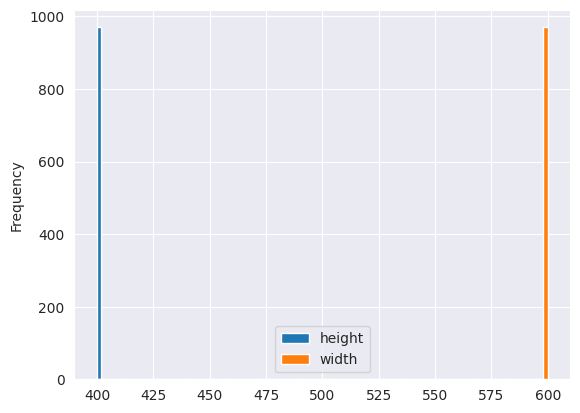

In [24]:
df.plot(kind='hist', y=['height', "width"], bins=100)

In [ ]:
batch = next(iter(train_dataset))
print(batch[0].shape, batch[1].shape)

(4, 0, 180, 320, 3) (4, 0, 180, 320, 3)


# Making Sample Image Patches

In [ ]:
train_low_light_images[0]

'./lol_dataset/our485/low/10.png'

In [59]:
from IPython.core.debugger import set_trace

sample_image = tf.io.decode_png(
    tf.io.read_file(train_enhanced_images[100]),
    channels=3,
    # dtype=tf.dtypes.uint8,
    name="image_input"
)

print(sample_image.shape)
max_ = tf.experimental.numpy.max(
    sample_image, axis=None, keepdims=None
)
min_ = tf.experimental.numpy.min(
    sample_image, axis=None, keepdims=None
)
print(f"max --> {max_}")
print(f"min --> {min_}")
print(f"dtype --> {sample_image.dtype}")
patch_size = [180, 320]
half_strides = list(map(lambda x: int(x/2), patch_size))
# set_trace()
extracted_patches = tf.image.extract_patches(
    images=tf.expand_dims(sample_image, 0),
    sizes=[1, *patch_size, 1],
    strides=[1, *half_strides, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
)


(400, 600, 3)
max --> 255
min --> 15
dtype --> <dtype: 'uint8'>


In [64]:
extracted_patches.shape

TensorShape([1, 3, 2, 172800])

In [63]:
tf.reshape(extracted_patches, [-1, *patch_size, 3]).shape

TensorShape([6, 180, 320, 3])

In [ ]:
from rich.console import Console
from rich.columns import Columns
from rich.panel import Panel
from rich.table import Table


Console().print(extracted_patches.shape)
resultant_patches_rows = extracted_patches.shape[1]
resultant_patches_cols = extracted_patches.shape[2]

tab = Table(title="[yellow]Patches", show_header=True)
tab.add_column("Rows", style='red')
tab.add_column("Columns", style='green')
tab.add_row(f"{resultant_patches_rows}", f"{resultant_patches_cols}")
Console().print(tab)


(1, 3, 2, 172800)

     Patches      
┏━━━━━━┳━━━━━━━━━┓
┃ Rows ┃ Columns ┃
┡━━━━━━╇━━━━━━━━━┩
│ 3    │ 2       │
└──────┴─────────┘

In [ ]:
extracted_patches[0].shape

TensorShape([3, 2, 172800])

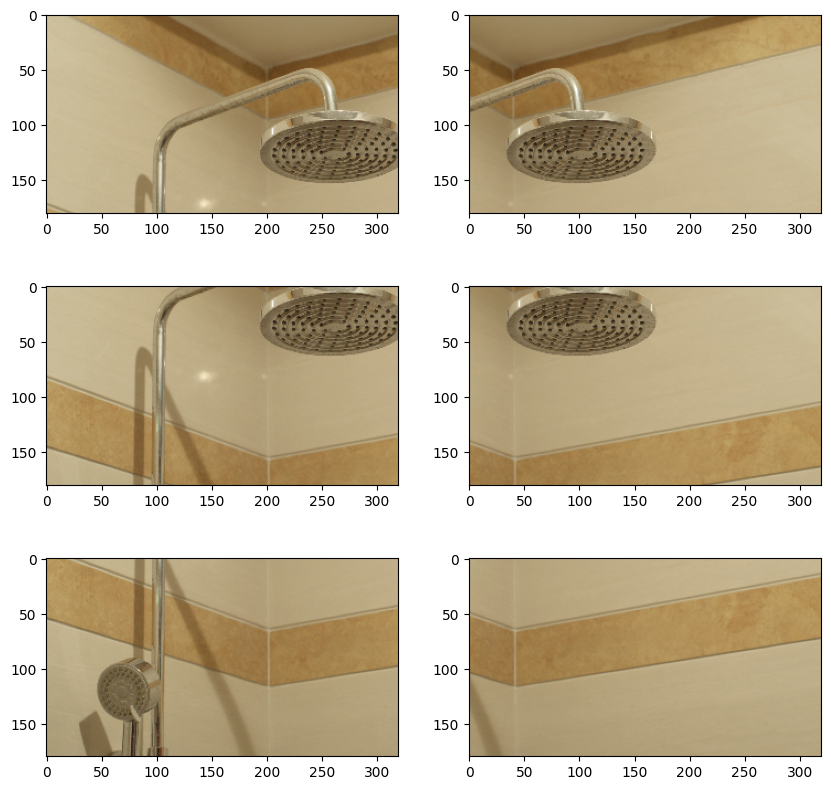

In [ ]:
plt.figure(figsize=(10, 10))
for imgs in extracted_patches:
    count = 0
    for r in range(resultant_patches_rows):
        for c in range(resultant_patches_cols):
            ax = plt.subplot(resultant_patches_rows, resultant_patches_cols, count+1)
            plt.imshow(tf.reshape(imgs[r, c], shape=(*patch_size, 3)).numpy())
            count += 1


# Creating Patches for Dataset 